**Goals:**
---
`- Train LDA model —> Use clean and bio-grammed data`\
`- Get Topic disgribution per talk —> Feature vector is a probability distribution`\
`- Predict review sentiment. `

In [1]:
import numpy as np
# import pandas
import pandas as pd

# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
import string

In [2]:
data = '/Users/patrickokwir/Desktop/Git_Projects/Ted-Talks-Recommender-System/Data_output/talks.csv'
df = pd.read_csv(data, index_col=0)
df.head()

,author,talk,description,likes,views
0,Conor Russomanno,a powerful new neurotech tool for augmenting y...,in an astonishing talk and tech demo neurotech...,4700,157930
1,Peter Singer,a modern argument for the rights of animals,why do we prioritize human rights over those o...,7600,254482
2,Sahar Zand,why iranians are cutting their hair for woman ...,filmmaker sahar zand vividly explores the ongo...,1100,393882
3,Shannon Odell,are solar panels worth it,today in many countries solar is the cheapest ...,3700,126251
4,Angus Hervey,why are we so bad at reporting good news,why is good news so rare in a special broadcas...,1200,415329


### **Goal 1: Create and train LDA Model**

In [4]:
# --------------------------------------------------Imports--------------------------------------------------#
import re
import nltk
import spacy
import gensim
import pyLDAvis
import nlp
nltk.download('stopwords')


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

#--------------------------------------------------Things to Note--------------------------------------------------#
#The following are key factors to obtaining good segregation topics:**

#The quality of text processing.
#The variety of topics the text talks about.
#The choice of topic modeling algorithm.
#The number of topics fed to the algorithm.
#The algorithms tuning parameters.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickokwir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#___________________________________________________Data Processing__________________________________________________#

# Convert to list
data = df['description'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', i) for i in data]

# Remove new line characters in data
data = [re.sub('\s+', ' ', i) for i in data]

# Remove distracting single quotes
data = [re.sub("\'", "", i) for i in data]

# import pprint
from pprint import pprint

<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \s
/var/folders/7f/4z7lvktj44g121hm_1s6v18h0000gn/T/ipykernel_67655/4165407693.py:7: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', i) for i in data]
/var/folders/7f/4z7lvktj44g121hm_1s6v18h0000gn/T/ipykernel_67655/4165407693.py:10: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', i) for i in data]


In [9]:
#break down each sentence into a list of words through tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['in', 'an', 'astonishing', 'talk', 'and', 'tech', 'demo', 'conor', 'russomanno', 'shares', 'his', 'work', 'building', 'braincomputer', 'interfaces', 'that', 'could', 'enable', 'us', 'to', 'control', 'the', 'external', 'world', 'with', 'our', 'minds', 'he', 'discusses', 'the', 'quickly', 'advancing', 'possibilities', 'of', 'this', 'field', 'including', 'the', 'promise', 'of', 'closedloop', 'system', 'that', 'could', 'both', 'record', 'and', 'stimulate', 'brain', 'activity', 'and', 'invites', 'neurohacker', 'christian', 'bayerlein', 'onto', 'the', 'ted', 'stage', 'to', 'fly', 'mindcontrolled', 'drone', 'by', 'using', 'biosensing', 'headset']]


In [10]:
# removing stop words using nltk
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Spacy lemmatization:
# Lemmatization is the process of converting a word to its base form.
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")


def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words

data_words_nostops = remove_stopwords(data_words)

# Do lemmatization keeping only nouns

data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN'])

In [15]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word.token2id)

{'activity': 0, 'biosensing': 1, 'brain': 2, 'braincomputer': 3, 'closedloop': 4, 'conor': 5, 'demo': 6, 'drone': 7, 'field': 8, 'headset': 9, 'interface': 10, 'mind': 11, 'possibility': 12, 'promise': 13, 'russomanno': 14, 'share': 15, 'stage': 16, 'system': 17, 'talk': 18, 'tech': 19, 'work': 20, 'world': 21, 'animal': 22, 'case': 23, 'conversation': 24, 'cruelty': 25, 'event': 26, 'exploitation': 27, 'facility': 28, 'factory': 29, 'farm': 30, 'food': 31, 'head': 32, 'image': 33, 'member': 34, 'membership': 35, 'mistreatment': 36, 'part': 37, 'philosopher': 38, 'quo': 39, 'right': 40, 'root': 41, 'singer': 42, 'speciesism': 43, 'status': 44, 'visit': 45, 'warning': 46, 'weight': 47, 'citizen': 48, 'country': 49, 'divorce': 50, 'fight': 51, 'filmmaker': 52, 'freedom': 53, 'hair': 54, 'hand': 55, 'hope': 56, 'life': 57, 'living': 58, 'morality': 59, 'point': 60, 'police': 61, 'protest': 62, 'regime': 63, 'secondclass': 64, 'solidarity': 65, 'struggle': 66, 'travel': 67, 'treatment': 68

In [19]:
# Create Corpus
# Term Document Frequency
texts = data_lemmatized

# Create Corpus
# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]]


In [20]:
#__________________________________________________________Build LDA Model______________________________________________________________#
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=10,
                                        random_state=100,
                                        chunksize=150,
                                        passes=10,
                                        per_word_topics=True)

In [21]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"talk" + 0.013*"share" + 0.012*"way" + 0.010*"power" + 0.008*"story" '
  '+ 0.008*"people" + 0.008*"change" + 0.007*"conversation" + 0.007*"energy" + '
  '0.007*"world"'),
 (1,
  '0.017*"talk" + 0.017*"life" + 0.012*"story" + 0.012*"art" + 0.011*"share" + '
  '0.008*"work" + 0.008*"music" + 0.008*"world" + 0.006*"experience" + '
  '0.006*"artist"'),
 (2,
  '0.019*"city" + 0.019*"world" + 0.012*"life" + 0.010*"way" + 0.010*"year" + '
  '0.010*"earth" + 0.009*"studio" + 0.007*"people" + 0.006*"planet" + '
  '0.006*"animation"'),
 (3,
  '0.016*"talk" + 0.015*"people" + 0.012*"work" + 0.012*"way" + 0.011*"share" '
  '+ 0.009*"thing" + 0.008*"day" + 0.008*"family" + 0.008*"time" + '
  '0.007*"company"'),
 (4,
  '0.028*"climate" + 0.017*"change" + 0.015*"world" + 0.013*"talk" + '
  '0.009*"carbon" + 0.009*"life" + 0.008*"body" + 0.007*"work" + 0.006*"share" '
  '+ 0.006*"people"'),
 (5,
  '0.020*"talk" + 0.012*"life" + 0.012*"world" + 0.010*"student" + '
  '0.009*"story" + 0.00

In [22]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.27928240906038165


In [23]:
# hyperparamters tuning 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics,random_state=100,
                                                chunksize=200,passes=10,per_word_topics=True,id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                        texts=data_lemmatized, start=2, limit=15, step=1)

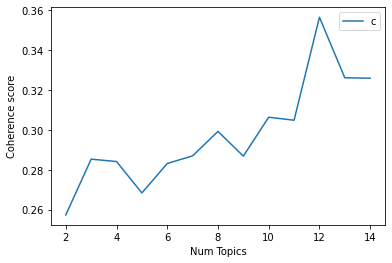

In [29]:
# Show graph
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Select the model and print the topics
optimal_model = model_list[12]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.040*"life" + 0.036*"talk" + 0.029*"share" + 0.028*"child" + 0.028*"kid" + '
  '0.024*"author" + 0.021*"word" + 0.021*"experience" + 0.019*"family" + '
  '0.018*"way"'),
 (1,
  '0.104*"brain" + 0.060*"body" + 0.038*"cell" + 0.033*"use" + 0.026*"line" + '
  '0.026*"disease" + 0.024*"death" + 0.021*"effect" + 0.019*"device" + '
  '0.017*"race"'),
 (2,
  '0.058*"day" + 0.051*"life" + 0.047*"music" + 0.040*"show" + 0.035*"planet" '
  '+ 0.034*"earth" + 0.030*"year" + 0.029*"history" + 0.026*"time" + '
  '0.025*"song"'),
 (3,
  '0.053*"thing" + 0.043*"design" + 0.039*"video" + 0.032*"talk" + '
  '0.032*"game" + 0.031*"way" + 0.025*"internet" + 0.021*"form" + 0.020*"look" '
  '+ 0.019*"mind"'),
 (4,
  '0.043*"designer" + 0.037*"school" + 0.029*"web" + 0.027*"question" + '
  '0.025*"answer" + 0.025*"book" + 0.025*"car" + 0.021*"society" + '
  '0.021*"world" + 0.020*"sense"'),
 (5,
  '0.074*"tool" + 0.043*"robot" + 0.042*"student" + 0.042*"education" + '
  '0.042*"team" + 0.040*"perfo

In [44]:
# make final model 
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,  
                                            alpha=0.01,
                                            eta='symmetric',
                                      per_word_topics=True)

In [45]:
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0,
  '0.015*"world" + 0.014*"science" + 0.013*"talk" + 0.010*"way" + '
  '0.010*"video" + 0.009*"web" + 0.009*"technology" + 0.008*"change" + '
  '0.008*"energy" + 0.007*"game"'),
 (1,
  '0.016*"art" + 0.014*"image" + 0.013*"brain" + 0.011*"story" + 0.011*"music" '
  '+ 0.011*"city" + 0.010*"animal" + 0.009*"food" + 0.009*"study" + '
  '0.008*"mind"'),
 (2,
  '0.016*"design" + 0.016*"life" + 0.011*"year" + 0.010*"minute" + '
  '0.009*"ocean" + 0.008*"world" + 0.008*"talk" + 0.008*"designer" + '
  '0.007*"nature" + 0.007*"product"'),
 (3,
  '0.032*"talk" + 0.020*"world" + 0.019*"people" + 0.018*"story" + '
  '0.018*"life" + 0.013*"way" + 0.013*"share" + 0.008*"work" + 0.008*"project" '
  '+ 0.007*"idea"')]


In [46]:
coherence_model_lda = CoherenceModel(model=lda_model_final, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.27243593194835025


In [47]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.177244 -0.008590       1        1  41.736095
0      0.087349 -0.155526       2        1  21.867380
2     -0.013902  0.237552       3        1  19.690568
1     -0.250691 -0.073436       4        1  16.705957, topic_info=        Term        Freq        Total Category  logprob  loglift
57      life  893.000000   893.000000  Default  30.0000  30.0000
92     story  798.000000   798.000000  Default  29.0000  29.0000
710  science  255.000000   255.000000  Default  28.0000  28.0000
520   design  343.000000   343.000000  Default  27.0000  27.0000
267      art  237.000000   237.000000  Default  26.0000  26.0000
..       ...         ...          ...      ...      ...      ...
337    water   66.308776   119.766672   Topic4  -5.3579   1.1982
15     share   75.213067   669.517736   Topic4  -5.2319  -0.3968
20      work   69.037281   402.346230   Topic4  -5.3176   0.0267
18      talk   77.585881  1585.103972   Topic4  -5.2008  -1.2276
21     world   68.502083  1167.898209   Topic4  -5.3253  -1.0467

[227 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
813       2  0.993373    ability
22        4  0.991074     animal
942       1  0.992476     answer
686       3  0.983719   approach
219       4  0.991341  architect
...     ...       ...        ...
21        4  0.059080      world
347       1  0.989820     writer
81        1  0.581262       year
81        3  0.415187       year
81        4  0.002372       year

[257 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [ ]:
# add topics to dataframe 